# Project: Investigate Relationships Between Sugar Consumption and Health In The United States

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> The following datasets have been compiled by Gapminder through various sources, including the UN, IMHE, FAOSTAT, and GDB 2017. They are relatively clean and easy to work with. Specifically, we are looking at [Life Expectancy from Birth v 11](https://www.gapminder.org/data/), [Sugar per person (g per day)](https://www.gapminder.org/data/), [Liver cancer, new cases per 100000 men](https://www.gapminder.org/data/), and [Liver cancer, new cases per 100000 women](https://www.gapminder.org/data/).<br>
>
> Sugar consumption has been under scrutiny recently with the claim that it causes many health problems. I would like to determine if there is any correlation between sugar consumption and life expectancy. If the claim that sugar is bad for your health is true, then maybe we would see a negative correlation between sugar consumption and life expectancy. We also look at sugar consumption and new liver cancer cases per 100,000 men and women. Is there a positive correlation between sugar consumption and new cases of liver cancer? 
>
> Before answering these questions, is there a general increasing or decreasing trend across any/all of the four identifiers?
>
> Note - the indicators are selected for United States, but we could have chosen any of 150 countries in our combined dataset.

Now that we have some questions we would like to answer and the relevant datasets, let's begin by loading Python's Numpy, Pandas, and Matplotlib library in order to analyze and visualize the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The following functions are used to clean and trim the datasets, are are futher described in the <a href="#wrangling">Data Wrangling</a> section of the report.

In [2]:
def munge(df):
    """Returns a DataFrame with Year as index and Country as column"""
    
    df_t = df.transpose().copy()
    old_columns = [x for x in range(len(df_t.columns))]
    new_columns = df_t.loc['country'].values
    countries_columns = dict(zip(old_columns, new_columns))
    df_t.rename(columns=countries_columns, inplace=True)
    df_t.drop(labels='country', axis=0, inplace=True)
    return df_t

In [3]:
def match_shape(df_1, df_2):
    """Returns matching sized DataFrames"""
    
    if df_1.shape != df_2.shape:
        # Remove indices in either DataFrame that are not in both so DataFrames have matching index
        rm_indices = list(set(df_1.index) ^ set(df_2.index))
        df_1.drop(index=(set(df_1.index) & set(rm_indices)), inplace=True)
        df_2.drop(index=(set(df_2.index) & set(rm_indices)), inplace=True)
        # Remove columns in either DataFrame that are not in both so DataFrames have matching columns.
        rm_columns = list(set(df_1.columns) ^ set(df_2.columns))
        df_1.drop(columns=(set(df_1.columns) & set(rm_columns)), inplace=True)
        df_2.drop(columns=(set(df_2.columns) & set(rm_columns)), inplace=True)
    return df_1, df_2

Let's load the datasets. We have four datasets:

<ul>
<li>df_cancer_m - new liver cancer cases per 100k male</li>
<li>df_cancer_f - new liver cancer cases per 100k female</li>
<li>df_life - life expectancy from birth given in years</li>
<li>df_sugar - sugar consumption in grams per person per day</li>
</ul>
I chose cancer data sets per 100k male/female rather than total number of cases given a population because as a population grows larger it is likely that cancer cases will also increase. With a case per 100k fixed population size it will be easier to see if cancer rates are actually increasing.

In [4]:
df_cancer_m = pd.read_csv('liver_cancer_new_cases_per_100000_men.csv')
df_cancer_f = pd.read_csv('liver_cancer_new_cases_per_100000_women.csv')
df_sugar = pd.read_csv('sugar_per_person_g_per_day.csv')
df_life = pd.read_csv('life_expectancy_years.csv')

Let's look at the data to get familiar with the variables and ontext, and to see what needs to be cleaned and modified before futher analysis.

In [5]:
df_cancer_m.head()

,country,1953,1954,1955,1956,1957,1958,1959,1960,1961,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.65,6.69,6.73,6.78,6.78,6.80,6.82,6.84,6.86,6.90
1,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.80,13.50,13.30,13.00,13.10,13.20,13.30,13.40,13.50,13.60
2,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.53,2.56,2.59,2.63,2.65,2.67,2.69,2.71,2.74,2.76
3,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.40,6.43,6.46,6.50,6.56,6.62,6.69,6.76,6.83,6.91
4,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.50,16.70,16.80,17.00,17.00,17.10,17.10,17.10,17.20,17.20


In [6]:
df_cancer_m.shape

(187, 65)

In [7]:
df_cancer_f.head()

,country,1953,1954,1955,1956,1957,1958,1959,1960,1961,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.94,5.93,5.91,5.92,5.87,5.85,5.82,5.79,5.77,5.75
1,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.14,4.90,4.68,4.47,4.48,4.49,4.51,4.52,4.54,4.56
2,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.44,1.46,1.47,1.48,1.49,1.50,1.51,1.52,1.53,1.54
3,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.40,2.40,2.41,2.42,2.44,2.46,2.49,2.51,2.54,2.57
4,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,7.16,7.15,7.13,7.08,7.02,6.97,6.92,6.87,6.83


In [8]:
df_cancer_f.shape

(187, 65)

In [9]:
df_life.head()

,country,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,Afghanistan,28.2,28.2,28.2,28.2,28.2,28.2,28.1,28.1,28.1,...,76.5,76.6,76.7,76.9,77.0,77.1,77.3,77.4,77.5,77.7
1,Albania,35.4,35.4,35.4,35.4,35.4,35.4,35.4,35.4,35.4,...,87.4,87.5,87.6,87.7,87.8,87.9,88.0,88.1,88.2,88.3
2,Algeria,28.8,28.8,28.8,28.8,28.8,28.8,28.8,28.8,28.8,...,88.3,88.4,88.5,88.6,88.7,88.8,88.9,89.0,89.1,89.2
3,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,...,78.7,78.9,79.0,79.1,79.3,79.4,79.5,79.7,79.8,79.9


In [10]:
df_life.shape

(187, 302)

In [11]:
df_sugar.head()

,country,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Afghanistan,14.4,12.8,13.2,15.5,16.3,16.7,17.4,17.8,14.5,...,15.5,18.6,19.7,20.8,23.4,23.3,24.3,24.8,25.4,24.5
1,Albania,31.0,31.8,34.3,36.6,37.0,37.7,38.3,38.6,40.9,...,55.0,58.6,67.2,75.5,102.0,117.0,113.0,122.0,129.0,131.0
2,Algeria,45.0,47.0,45.3,46.7,43.7,45.1,47.3,48.1,45.8,...,84.3,75.5,77.9,86.7,78.5,85.3,85.6,74.9,82.8,78.2
3,Angola,25.2,30.6,33.6,29.5,29.5,28.9,29.4,34.5,30.0,...,39.3,37.1,38.3,39.5,44.1,40.2,38.9,40.1,42.7,44.7
4,Antigua and Barbuda,1140.0,1160.0,1410.0,1080.0,764.0,492.0,350.0,188.0,311.0,...,93.1,79.7,85.0,87.3,89.2,87.6,87.6,79.6,87.9,90.1


In [12]:
df_sugar.isnull().any().any()

True

In [13]:
df_sugar.shape

(168, 54)

It looks like there are null values in all of the four datasets. There all also mismatched shapes across the datasets which indicates that the same years are not accounted for in all datasets (rows), and not all countries are accounted for in all datasets (columns). 

<a id='wrangling'></a>
## Data Wrangling
### General Properties
> There are two functions in the code cells above that I created to be used in the data wrangling process. They are "munge" and "match_shape". 
>
>Munge transposes the DataFrame and then swaps the first two rows so that the year becomes the index and the countries and their selected indicator become the columns. This is done so we can compare across indicators for a given country. The way the data was originally arranged was good for looking at trends from past to present for different countries, but not for comparing different indicators.
>
> Match_shape function is used to match the shape of the DataFrames so that null data is ignored and the frames can be merged into a single DataFrame.

Next we use munge to transpose the index (years) and columns (countries), as well as trim the datasets down to match the size of the smallest dataset in order to be able to effectively visualize each indicator. 

In [14]:
df_cancer_m, df_cancer_f, df_life, df_sugar = map(munge, (df_cancer_m, df_cancer_f, df_life, df_sugar))

I would also like to remove either years (rows) or countries (columns) that have missing data. I chose to remove rather than fill in missing data because mean values or interpolations would be misleading because we need to know exact information for given indicators. For example, when looking at new cancer cases it would be misleading to use the mean to fill in missing values because we don't know if new cases actually increased or decreased, and to what extent. 

In [15]:
df_cancer_m.dropna(axis=0, inplace=True)
df_cancer_f.dropna(axis=0, inplace=True)
df_sugar.dropna(axis=1, inplace=True)
df_life.dropna(axis=1, inplace=True)

Let's match the shapes of our datasets before merging.

In [16]:
df_sugar, df_life = match_shape(df_sugar, df_life)
df_cancer_m, df_cancer_f = match_shape(df_cancer_m, df_cancer_f)
df_sugar, df_cancer_m = match_shape(df_sugar, df_cancer_m)

In [17]:
# Get list of countries before DataFrames are merged with indicator suffixes
countries = [country.lower().replace(' ', '_') for country in df_sugar.columns]

Here, we are renaming the columns with suffixes relevant to each indicatior. 

In [18]:
df_sugar.rename(mapper=lambda x: x.lower().replace(' ', '_') + "_sugar", axis=1, inplace=True)
df_life.rename(mapper=lambda x: x.lower().replace(' ', '_') + "_life", axis=1, inplace=True)
df_cancer_m.rename(mapper=lambda x: x.lower().replace(' ', '_') + "_cancer_m", axis=1, inplace=True)
df_cancer_f.rename(mapper=lambda x: x.lower().replace(' ', '_') + "_cancer_f", axis=1, inplace=True)

Merge all DataFrames
<ul>
<li>df_cmb - combined DataFrames (df_cancer_m, df_cancer_f, df_life, df_sugar)</li>
</ul>

In [19]:
df_cmb_1 = pd.merge(df_cancer_m, df_cancer_f, left_index=True, right_index=True, how='inner')
df_cmb_2 = pd.merge(df_life, df_sugar, left_index=True, right_index=True, how='inner')
df_cmb = pd.merge(df_cmb_1, df_cmb_2, left_index=True, right_index=True, how='inner')

Sort columns in order to make it easier to verify our merge worked correctly.

In [20]:
df_cmb = df_cmb.reindex(sorted(df_cmb.columns), axis=1);

In [21]:
df_cmb.head()

,afghanistan_cancer_f,afghanistan_cancer_m,afghanistan_life,afghanistan_sugar,albania_cancer_f,albania_cancer_m,albania_life,albania_sugar,algeria_cancer_f,algeria_cancer_m,...,yemen_life,yemen_sugar,zambia_cancer_f,zambia_cancer_m,zambia_life,zambia_sugar,zimbabwe_cancer_f,zimbabwe_cancer_m,zimbabwe_life,zimbabwe_sugar
1990,5.58,6.51,52.6,10,7.18,14.6,73.3,49.9,2.48,4.01,...,58.7,59.3,6.48,9.56,50.7,46.5,15.4,29,60.9,57.5
1991,5.61,6.52,52.4,9.61,7.3,15,73,50.2,2.28,3.69,...,59.2,56.5,6.62,9.53,49.5,45.7,15,28.3,59.5,55.9
1992,5.66,6.55,52.9,10.8,7.42,15.5,73.4,51.2,2.1,3.39,...,59.6,57.2,6.77,9.52,48.4,45.1,14.6,27.7,57.6,57
1993,5.71,6.58,53.1,9.12,7.54,15.9,73.9,76.1,1.94,3.13,...,60,56.4,6.92,9.5,47.6,44.5,14.3,27.1,55.6,56.4
1994,5.77,6.6,52.7,8.22,7.67,16.4,74.5,97.5,1.79,2.88,...,60.2,56.2,7.08,9.49,46.8,40.6,13.9,26.5,53.8,56.6


Let's make sure the datatype for df_cmb is appropriate.

In [22]:
df_cmb.dtypes

afghanistan_cancer_f    object
afghanistan_cancer_m    object
afghanistan_life        object
afghanistan_sugar       object
albania_cancer_f        object
                         ...  
zambia_sugar            object
zimbabwe_cancer_f       object
zimbabwe_cancer_m       object
zimbabwe_life           object
zimbabwe_sugar          object
Length: 604, dtype: object

Finally, let's convert all of our datatypes to 'float64' so that we can correctly visualize the data.

In [23]:
df_cmb = df_cmb.astype('float64')

In [24]:
df_cmb.dtypes

afghanistan_cancer_f    float64
afghanistan_cancer_m    float64
afghanistan_life        float64
afghanistan_sugar       float64
albania_cancer_f        float64
                         ...   
zambia_sugar            float64
zimbabwe_cancer_f       float64
zimbabwe_cancer_m       float64
zimbabwe_life           float64
zimbabwe_sugar          float64
Length: 604, dtype: object

<a id='eda'></a>
## Exploratory Data Analysis

> We will explore data for the United States. However, there are over 150 countries in our combined dataset that can be explored. It would be interesting to see if there are differences in trends between countries, however these questions are beyond the scope of this report.

### Is sugar consumption increasing with time? Are new cases of male/female liver cancer increasing with time? Is life expectancy increasing with time? 

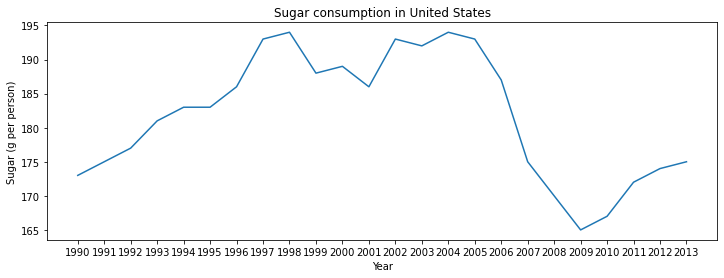

In [25]:
plt.figure(figsize=(12,4))
plt.plot(df_cmb['united_states_sugar'])
plt.title('Sugar consumption in United States')
plt.xlabel('Year')
plt.ylabel('Sugar (g per person)')
plt.show()

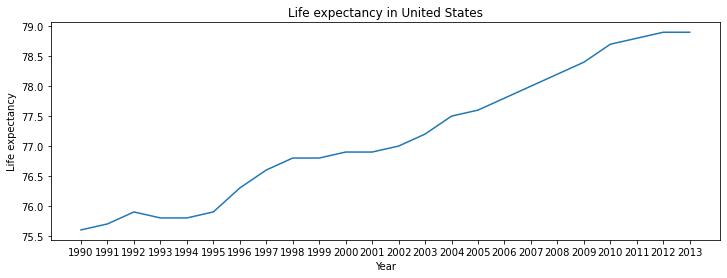

In [26]:
plt.figure(figsize=(12,4))
plt.plot(df_cmb['united_states_life'])
plt.title('Life expectancy in United States')
plt.xlabel('Year')
plt.ylabel('Life expectancy')
plt.show()

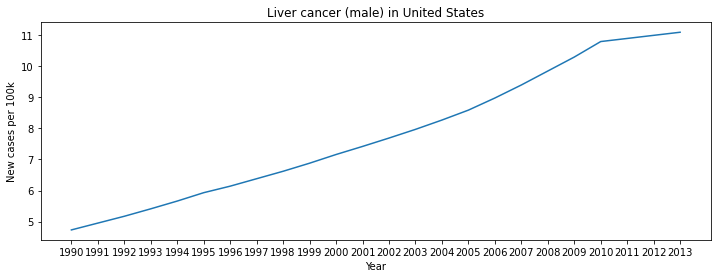

In [27]:
plt.figure(figsize=(12,4))
plt.plot(df_cmb['united_states_cancer_m'])
plt.title('Liver cancer (male) in United States')
plt.xlabel('Year')
plt.ylabel('New cases per 100k')
plt.show()

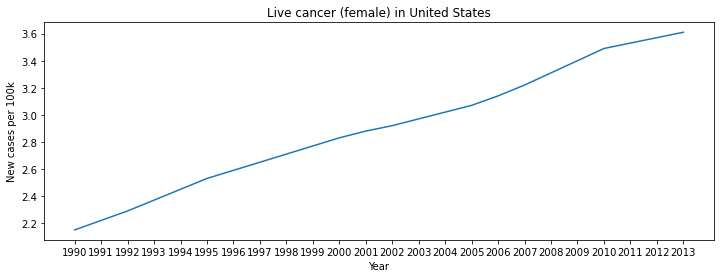

In [28]:
plt.figure(figsize=(12,4))
plt.plot(df_cmb['united_states_cancer_f'])
plt.title('Live cancer (female) in United States')
plt.xlabel('Year')
plt.ylabel('New cases per 100k')
plt.show()

Clearly, all four indicators are increasing with time! However, sugar consumption declined from 1998 to 2001, then again from 2004 to 2009. The two cancer indicators have been steadily increasing since 1990. Interestingly, life expectancy during 1998 to 2001 flatlined, but otherwise has been increasing since 1990.

### Is sugar consumption correlated with lifespan or a greater number of occurrences of liver cancer in men or women?

In order to determine this, let's compute pairwise correlation across two indicators. Values closer to -1 show a negative correlation meaning identifiers are moving in opposite directions. Values closer to 1 show a positive correlation meaning values move in same direction.

In [29]:
corr_life = df_cmb['united_states_sugar'].corr(df_cmb['united_states_life'])
corr_cancer_m = df_cmb['united_states_sugar'].corr(df_cmb['united_states_cancer_m'])
corr_cancer_f = df_cmb['united_states_sugar'].corr(df_cmb['united_states_cancer_f'])

In [30]:
print("Sugar correlation vs life expectancy: {}, \ncancer (m): {}, \ncancer (f): {}" \
      .format(corr_life, corr_cancer_m, corr_cancer_f))

Sugar correlation vs life expectancy: -0.35670810356981575, 
cancer (m): -0.38380235053987793, 
cancer (f): -0.306486604792611


Based on this information, it appears that there is a weak negative correlation between sugar consumption and life expectancy, and sugar consumption and cancer rates in both men and women.

Let's compute some descriptive statistics to better understand our data, and see if anything stands out.

In [31]:
df_cmb[['united_states_cancer_m', 'united_states_cancer_f', 'united_states_sugar', 'united_states_life']].describe()

,united_states_cancer_m,united_states_cancer_f,united_states_sugar,united_states_life
count,24.000000,24.000000,24.000000,24.000000
mean,7.804167,2.903750,181.875000,77.166667
std,2.093968,0.445195,9.256314,1.104798
min,4.730000,2.150000,165.000000,75.600000
25%,6.087500,2.575000,174.750000,76.200000
50%,7.555000,2.900000,183.000000,76.950000
75%,9.512500,3.242500,189.750000,78.050000
max,11.100000,3.610000,194.000000,78.900000


Let's visualize these relationships using scatterplots.

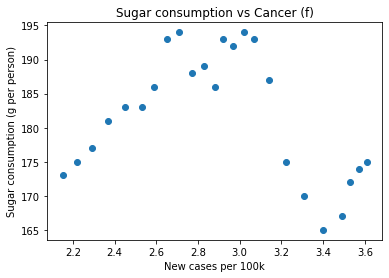

In [32]:
plt.figure()
plt.scatter(y=df_cmb['united_states_sugar'], x=df_cmb["united_states_cancer_f"])
plt.title("Sugar consumption vs Cancer (f)")
plt.ylabel("Sugar consumption (g per person)")
plt.xlabel("New cases per 100k")
plt.show()

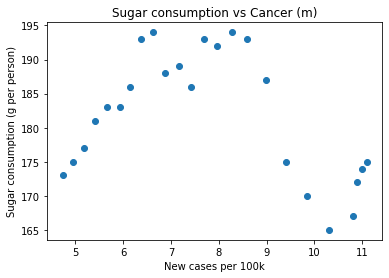

In [33]:
plt.figure()
plt.scatter(y=df_cmb['united_states_sugar'], x=df_cmb["united_states_cancer_m"])
plt.title("Sugar consumption vs Cancer (m)")
plt.ylabel("Sugar consumption (g per person)")
plt.xlabel("New cases per 100k")
plt.show()

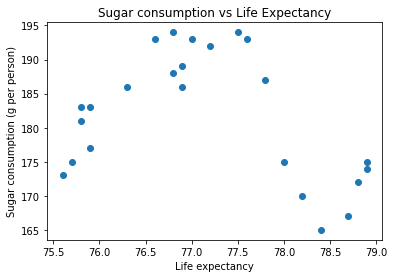

In [34]:
plt.figure()
plt.scatter(y=df_cmb['united_states_sugar'], x=df_cmb["united_states_life"])
plt.title("Sugar consumption vs Life Expectancy")
plt.ylabel("Sugar consumption (g per person)")
plt.xlabel("Life expectancy")
plt.show()

<a id='conclusions'></a>
## Conclusions

> Life expectancy, new liver cancer cases per 100k male, and new liver cases per 100k female have been increasing since 1990, whether sugar consumption increases or decreases. 

> It does look like there is a small negative correlation between sugar consumption and the life expectancy. This shows that as sugar consumption decreased, life expectancy increased. So sugar consumption may be correlated with higher life expectancy. However, there are many variables to consider when looking at life expectancy. It would be great to look at more.

> I was suprised to see there is no positive correlation between sugar consumption and liver cancer. Again, there are many variables to consider when predicting whether or not a person will get cancer. However, this was interesting to see because many experts believe sugar does influence cancer progression.  

> It is also interesting to see from the descriptive statistics that in males new liver cancer cases are nearly triple that of females, regardless of sugar consumption. Why is this?

> Note that correlation does not equal causation, but it can still give us an idea of whether or not there is any correlation that would warrant further investigation.